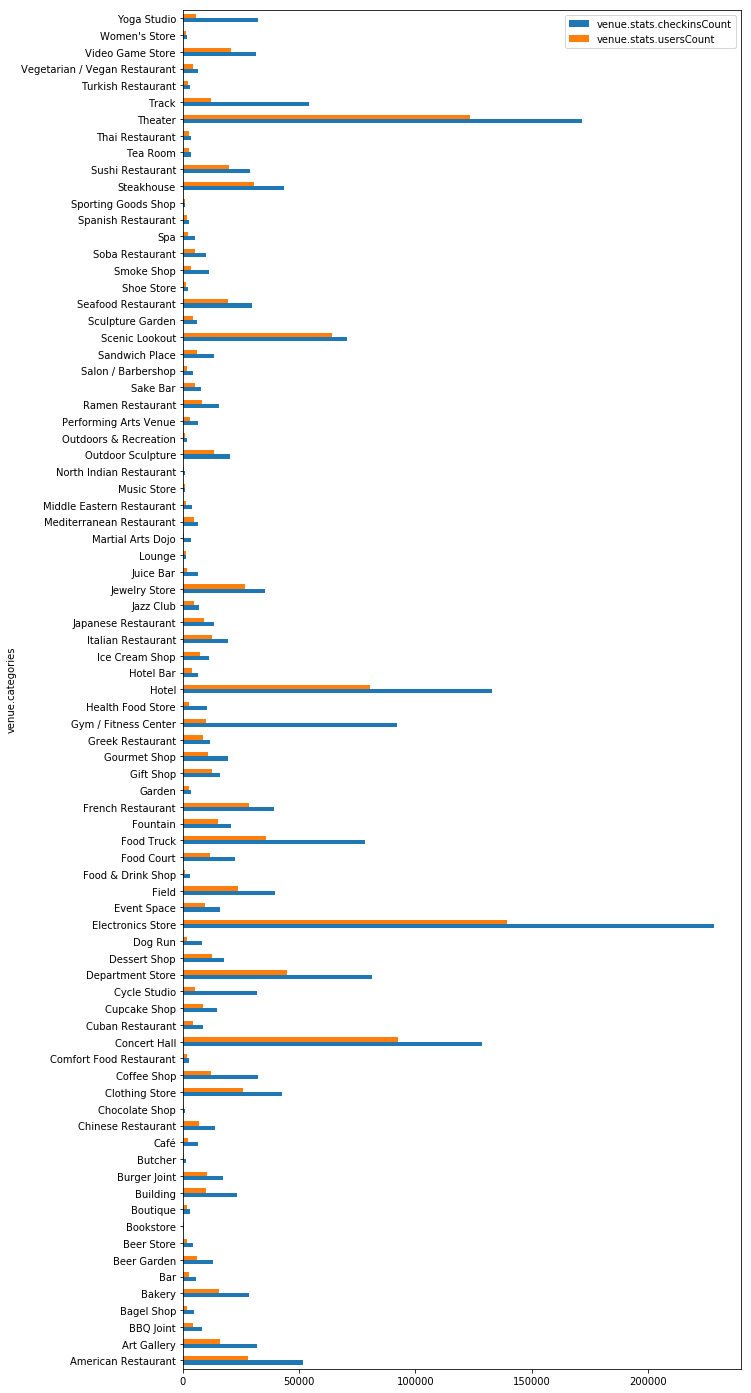

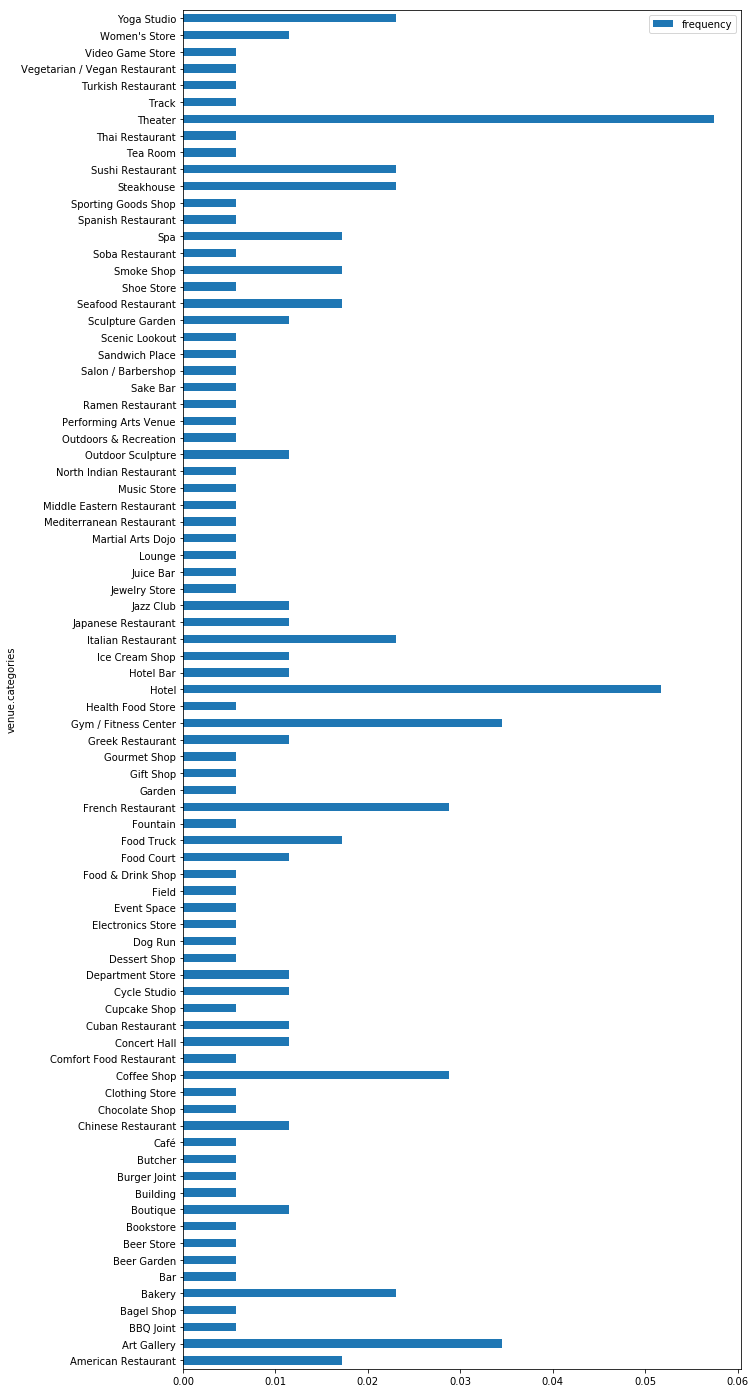

In [2]:
%matplotlib inline
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt

secrets = {
    'client_id':"33D0NQYSP2AKAIEEZJNWEPSIU23UAGAXJ1EL0B1J13I4XGHC",
    'client_secret':"ONNNBGVMFHQ3TVUXDVWYVWDDQSZEM42XBO23BUBGC3ZOZ2V0",
    'v': "20170512"
}

# location
def lat_long(address):
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    longitude, latitude = location.longitude, location.latitude
    return {'ll': '{},{}'.format(latitude, longitude)}


def fetch_venues(address, params, radius=2000):
    api_url = "https://api.foursquare.com/v2/venues/explore"
    params.update(lat_long(address))
    params.update({'radius': radius}) 
    response = requests.get(api_url, params=params).json()
    
    
    totalResults = response['response']['totalResults']
    venues = []
    while len(venues) != totalResults:
        venues.extend(response['response']['groups'][0]['items'])
        params.update({'offset': params.get('offset', 0) + per_page_limit})
        response = requests.get(api_url, params=params).json()
    response = requests.get(api_url, params=params).json()

    return venues

def fetch_trend(params, address, radius=5000):
    params.update(lat_long(address))
    params.update({'radius': radius})
    url = "https://api.foursquare.com/v2/venues/trending"
    response = requests.get(url, params=params).json()
    return response


per_page_limit = 50 
params = {
    'v': '20170513',
    'limit': per_page_limit,
    'offset': 0
}
params.update(secrets)




def remove_public_categories(df, contains=['Station', 'Plaza', 'Museum', 'University', 'Park', 'Church', 'Theatre']):
    for pub_cat in contains:
        df = df[~df.index.str.contains(pub_cat)].copy()
    return df



address = "1218 2nd Ave, New York, NY 10065"

venues = fetch_venues(address, params)
df = json_normalize(venues)
df['venue.categories'] = df['venue.categories'].apply(lambda x: x[0]['name'])
b = df[['venue.categories', 'venue.ratingSignals', 'venue.stats.checkinsCount', 'venue.stats.usersCount']].copy()
s = pd.value_counts(df['venue.categories'].values.flatten(), normalize=1)
c = b.groupby('venue.categories').agg('sum')
c = remove_public_categories(c)
c['frequency'] = s


c[[1,2]].plot.barh(figsize=(10,25))
c[[3]].plot.barh(figsize=(10,25))